In [7]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline as SkPipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    PrecisionRecallDisplay
)
import joblib
import os

# Configure visualizations
sns.set(style="whitegrid", palette="pastel")
%matplotlib inline

# Define data paths
data_dir = r"C:\Users\yusuf\Desktop\10Academy\week8\Data"
assets_dir = os.path.join(data_dir, "assets")

# Load processed datasets
creditcard = pd.read_csv(os.path.join(data_dir, 'creditcard_processed.csv'))
ecommerce = pd.read_csv(os.path.join(data_dir, 'fraud_data_processed.csv'))

# Fix NaN in e-commerce data (for new users with no previous purchase)
ecommerce['time_since_last_purchase'] = ecommerce['time_since_last_purchase'].fillna(24*365*10)  # 10 years in hours

# Verify no NaNs
print("✅ Data loaded and fixed:")
print(f"- Credit Card: {creditcard.shape}")
print(f"- E-commerce: {ecommerce.shape}")
print(f"NaN in e-commerce: {ecommerce.isnull().sum().sum()}")

✅ Data loaded and fixed:
- Credit Card: (283726, 31)
- E-commerce: (151112, 11)
NaN in e-commerce: 0


In [8]:
# Split features and target
X_ecom = ecommerce.drop('class', axis=1)
y_ecom = ecommerce['class']

# Identify feature types
cat_features = ['source', 'browser', 'sex', 'country']
num_features = ['purchase_value', 'age', 'time_since_signup', 'purchase_day', 
                'purchase_hour', 'time_since_last_purchase']

# Create robust preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SkPipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('scaler', StandardScaler())
        ]), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
    ]
)

# Split data
X_train_ecom, X_test_ecom, y_train_ecom, y_test_ecom = train_test_split(
    X_ecom, y_ecom, test_size=0.2, random_state=42, stratify=y_ecom
)

print(f"E-commerce train shape: {X_train_ecom.shape}, test shape: {X_test_ecom.shape}")
print(f"Fraud rate - Train: {y_train_ecom.mean():.4f}, Test: {y_test_ecom.mean():.4f}")

E-commerce train shape: (120889, 10), test shape: (30223, 10)
Fraud rate - Train: 0.0936, Test: 0.0936


In [9]:
# Split features and target
X_cc = creditcard.drop('Class', axis=1)
y_cc = creditcard['Class']

# Scale numerical features
scaler = StandardScaler()
X_cc_scaled = scaler.fit_transform(X_cc)

# Split data
X_train_cc, X_test_cc, y_train_cc, y_test_cc = train_test_split(
    X_cc_scaled, y_cc, test_size=0.2, random_state=42, stratify=y_cc
)

print(f"Credit Card train shape: {X_train_cc.shape}, test shape: {X_test_cc.shape}")
print(f"Fraud rate - Train: {y_train_cc.mean():.6f}, Test: {y_test_cc.mean():.6f}")

Credit Card train shape: (226980, 30), test shape: (56746, 30)
Fraud rate - Train: 0.001665, Test: 0.001674


In [10]:
# E-commerce pipeline
ecom_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),
    ('classifier', None)
])

# Credit card pipeline
cc_pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy=0.1, random_state=42)),
    ('classifier', None)
])

# Model parameters
logreg_params = {
    'class_weight': 'balanced',
    'max_iter': 1000,
    'random_state': 42,
    'n_jobs': -1
}

xgb_params = {
    'scale_pos_weight': len(y_train_ecom[y_train_ecom==0]) / len(y_train_ecom[y_train_ecom==1]),
    'eval_metric': 'aucpr',
    'random_state': 42,
    'n_jobs': -1
}

print("✅ Pipelines created")

✅ Pipelines created



🚀 Training Logistic Regression on E-commerce data...
✅ Logistic Regression evaluation:
- Accuracy: 0.6565
- ROC AUC: 0.7510
- PR AUC: 0.3903

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.65      0.77     27393
           1       0.17      0.70      0.28      2830

    accuracy                           0.66     30223
   macro avg       0.56      0.67      0.53     30223
weighted avg       0.88      0.66      0.73     30223



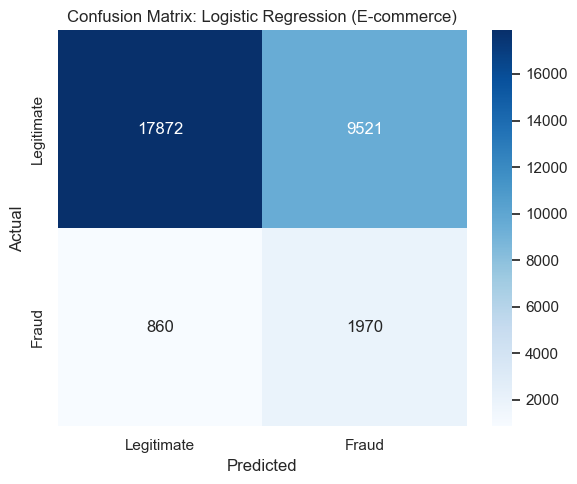

<Figure size 800x600 with 0 Axes>

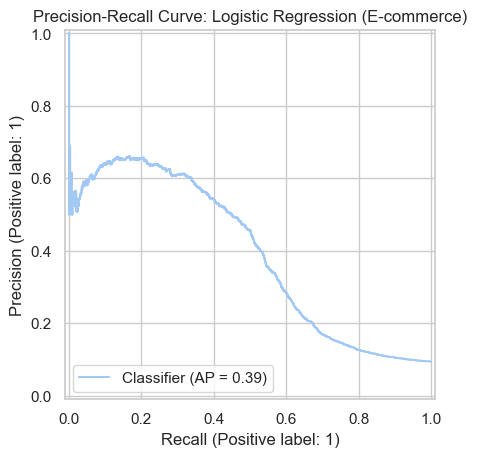


🚀 Training XGBoost on E-commerce data...
✅ XGBoost evaluation:
- Accuracy: 0.9384
- ROC AUC: 0.7744
- PR AUC: 0.6151

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     27393
           1       0.72      0.55      0.63      2830

    accuracy                           0.94     30223
   macro avg       0.84      0.77      0.80     30223
weighted avg       0.93      0.94      0.93     30223



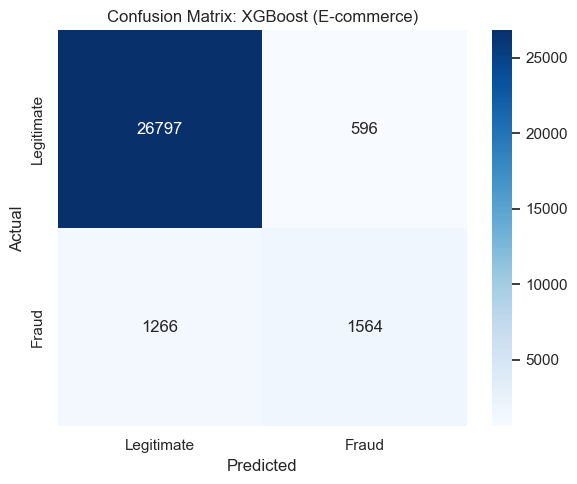

<Figure size 800x600 with 0 Axes>

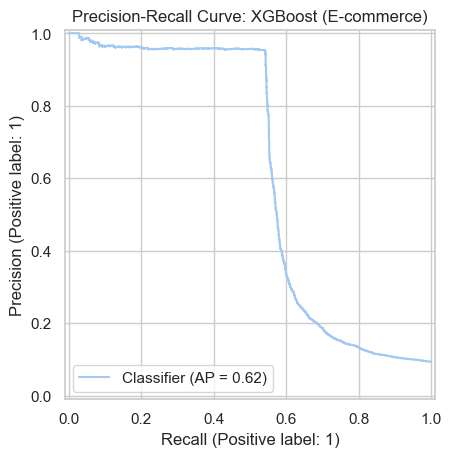

In [11]:
def train_evaluate_model(pipeline, X_train, y_train, X_test, y_test, model_name, dataset_name):
    """Train and evaluate a model"""
    print(f"\n🚀 Training {model_name} on {dataset_name} data...")
    
    # Train model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = pipeline.score(X_test, y_test)
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    report = classification_report(y_test, y_pred)
    
    print(f"✅ {model_name} evaluation:")
    print(f"- Accuracy: {accuracy:.4f}")
    print(f"- ROC AUC: {roc_auc:.4f}")
    print(f"- PR AUC: {pr_auc:.4f}")
    print("\nClassification Report:")
    print(report)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Legitimate', 'Fraud'],
                yticklabels=['Legitimate', 'Fraud'])
    plt.title(f'Confusion Matrix: {model_name} ({dataset_name})')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.savefig(os.path.join(assets_dir, f'cm_{model_name.lower()}_ecom.png'))
    plt.show()
    
    # Plot precision-recall curve
    plt.figure(figsize=(8, 6))
    PrecisionRecallDisplay.from_predictions(y_test, y_proba)
    plt.title(f'Precision-Recall Curve: {model_name} ({dataset_name})')
    plt.grid(True)
    plt.savefig(os.path.join(assets_dir, f'pr_{model_name.lower()}_ecom.png'))
    plt.show()
    
    return {
        'model': model_name,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'model_object': pipeline
    }

# Train and evaluate models for e-commerce data
ecom_results = {}

# Logistic Regression
ecom_pipeline.set_params(classifier=LogisticRegression(**logreg_params))
ecom_results['logreg'] = train_evaluate_model(
    ecom_pipeline, 
    X_train_ecom, 
    y_train_ecom, 
    X_test_ecom, 
    y_test_ecom,
    'Logistic Regression',
    'E-commerce'
)

# XGBoost
ecom_pipeline.set_params(classifier=XGBClassifier(**xgb_params))
ecom_results['xgb'] = train_evaluate_model(
    ecom_pipeline, 
    X_train_ecom, 
    y_train_ecom, 
    X_test_ecom, 
    y_test_ecom,
    'XGBoost',
    'E-commerce'
)


🚀 Training Logistic Regression on Credit Card data...
✅ Logistic Regression evaluation:
- Accuracy: 0.9731
- ROC AUC: 0.9627
- PR AUC: 0.6780

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56651
           1       0.05      0.87      0.10        95

    accuracy                           0.97     56746
   macro avg       0.53      0.92      0.54     56746
weighted avg       1.00      0.97      0.98     56746



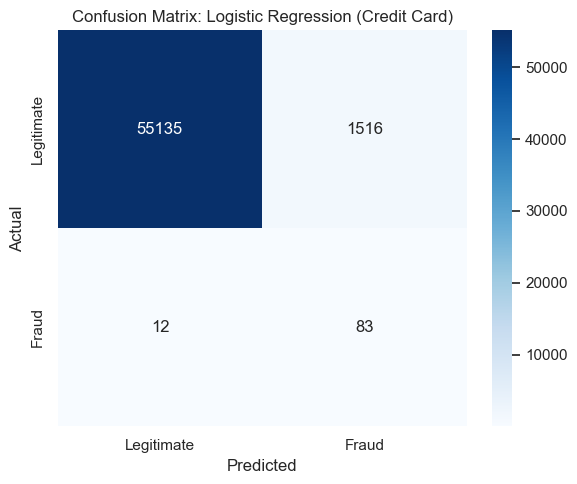

<Figure size 800x600 with 0 Axes>

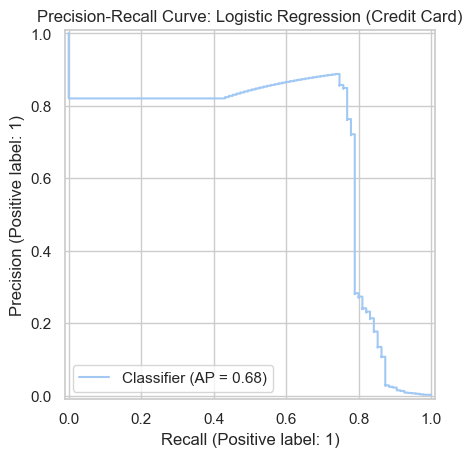


🚀 Training XGBoost on Credit Card data...
✅ XGBoost evaluation:
- Accuracy: 0.9992
- ROC AUC: 0.9609
- PR AUC: 0.8087

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.77      0.79      0.78        95

    accuracy                           1.00     56746
   macro avg       0.88      0.89      0.89     56746
weighted avg       1.00      1.00      1.00     56746



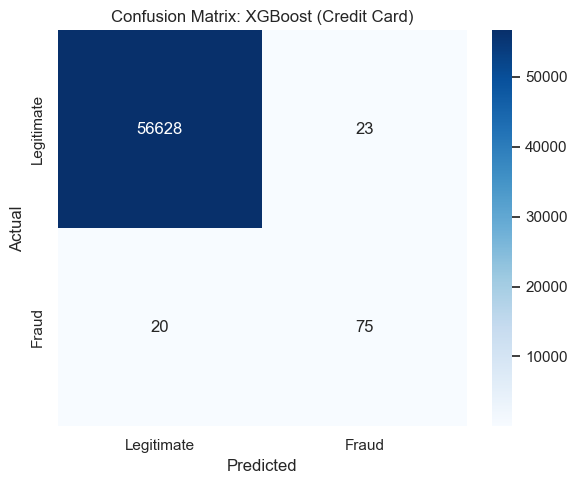

<Figure size 800x600 with 0 Axes>

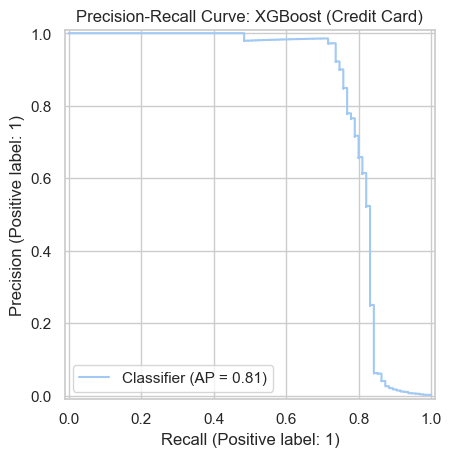

In [12]:
def train_evaluate_cc(pipeline, X_train, y_train, X_test, y_test, model_name):
    """Train and evaluate model for credit card data"""
    print(f"\n🚀 Training {model_name} on Credit Card data...")
    
    # Train model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = pipeline.score(X_test, y_test)
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    report = classification_report(y_test, y_pred)
    
    print(f"✅ {model_name} evaluation:")
    print(f"- Accuracy: {accuracy:.4f}")
    print(f"- ROC AUC: {roc_auc:.4f}")
    print(f"- PR AUC: {pr_auc:.4f}")
    print("\nClassification Report:")
    print(report)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Legitimate', 'Fraud'],
                yticklabels=['Legitimate', 'Fraud'])
    plt.title(f'Confusion Matrix: {model_name} (Credit Card)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.savefig(os.path.join(assets_dir, f'cm_{model_name.lower()}_cc.png'))
    plt.show()
    
    # Plot precision-recall curve
    plt.figure(figsize=(8, 6))
    PrecisionRecallDisplay.from_predictions(y_test, y_proba)
    plt.title(f'Precision-Recall Curve: {model_name} (Credit Card)')
    plt.grid(True)
    plt.savefig(os.path.join(assets_dir, f'pr_{model_name.lower()}_cc.png'))
    plt.show()
    
    return {
        'model': model_name,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'model_object': pipeline
    }

# Train and evaluate models for credit card data
cc_results = {}

# Logistic Regression
cc_pipeline.set_params(classifier=LogisticRegression(**logreg_params))
cc_results['logreg'] = train_evaluate_cc(
    cc_pipeline, 
    X_train_cc, 
    y_train_cc, 
    X_test_cc, 
    y_test_cc,
    'Logistic Regression'
)

# XGBoost
cc_pipeline.set_params(classifier=XGBClassifier(**xgb_params))
cc_results['xgb'] = train_evaluate_cc(
    cc_pipeline, 
    X_train_cc, 
    y_train_cc, 
    X_test_cc, 
    y_test_cc,
    'XGBoost'
)

In [15]:
# Compare model performance
def compare_models(results, dataset_name):
    """Compare model performance and select the best"""
    print(f"\n Model Comparison for {dataset_name}")
    comparison = []
    for name, res in results.items():
        comparison.append({
            'Model': name,
            'PR AUC': res['pr_auc'],
            'ROC AUC': res['roc_auc'],
            'Accuracy': res['accuracy']
        })
    
    df_compare = pd.DataFrame(comparison)
    print(df_compare)
    
    # Select best model based on PR AUC (most important for fraud detection)
    best_model = max(results.items(), key=lambda x: x[1]['pr_auc'])
    print(f"\n Best model for {dataset_name}: {best_model[0]} (PR AUC: {best_model[1]['pr_auc']:.4f})")
    
    return best_model[1]['model_object']

# Compare and select best models
print("\n" + "="*60)
best_ecom_model = compare_models(ecom_results, 'E-commerce')
print("\n" + "="*60)
best_cc_model = compare_models(cc_results, 'Credit Card')
print("\n" + "="*60)

# Save best models
joblib.dump(best_ecom_model, os.path.join(data_dir, 'best_ecom_model.pkl'))
joblib.dump(best_cc_model, os.path.join(data_dir, 'best_cc_model.pkl'))
print("\n💾 Saved best models to disk")



 Model Comparison for E-commerce
    Model    PR AUC   ROC AUC  Accuracy
0  logreg  0.390343  0.750983  0.656520
1     xgb  0.615072  0.774352  0.938391

 Best model for E-commerce: xgb (PR AUC: 0.6151)


 Model Comparison for Credit Card
    Model    PR AUC   ROC AUC  Accuracy
0  logreg  0.677975  0.962674  0.973073
1     xgb  0.808697  0.960885  0.999242

 Best model for Credit Card: xgb (PR AUC: 0.8087)


 Saved best models to disk


In [16]:
# Save test sets with predictions for SHAP analysis
def save_test_sets(model, X_test, y_test, dataset_name, preprocessor=None):
    """Save test sets with predictions for explainability"""
    if preprocessor:
        X_test_trans = preprocessor.transform(X_test)
    else:
        X_test_trans = X_test
        
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Get feature names
    if dataset_name == 'ecom':
        num_feat = num_features
        cat_feat = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_features)
        feature_names = np.concatenate([num_feat, cat_feat])
    else:
        feature_names = [f'V{i}' for i in range(1, 29)] + ['Time', 'Amount']
    
    test_df = pd.DataFrame(X_test_trans, columns=feature_names)
    test_df['actual'] = y_test
    test_df['predicted'] = y_pred
    test_df['probability'] = y_proba
    
    test_df.to_csv(os.path.join(data_dir, f'test_{dataset_name}.csv'), index=False)
    print(f"💾 Saved test set for {dataset_name}")

# For e-commerce
save_test_sets(best_ecom_model, X_test_ecom, y_test_ecom, 'ecom', preprocessor)

# For credit card
save_test_sets(best_cc_model, X_test_cc, y_test_cc, 'cc')

print("\n✅ TASK 2 COMPLETE! READY FOR TASK 3 (MODEL EXPLAINABILITY)")

💾 Saved test set for ecom
💾 Saved test set for cc

✅ TASK 2 COMPLETE! READY FOR TASK 3 (MODEL EXPLAINABILITY)
